In [ ]:
# reading in files from google drive to speed up run time
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#Loading packages

In [ ]:
!pip install MissForestExtra


In [ ]:
!pip install miceforest

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn.neighbors._base
import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
import miceforest as mf
from MissForestExtra import MissForestExtra

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbpipe

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier,  plot_tree

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix,\
precision_recall_fscore_support, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV,\
cross_validate, cross_val_predict, cross_val_score

# Reading in the data

In [ ]:
df = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Phase3-Project-Data/df_master_people_crashes_2018_2023.csv")

In [ ]:
# Adding target columns
df['Total_Serious_Injuries']=df['INJURIES_FATAL_c']+df['INJURIES_INCAPACITATING_c']
df['Has_Serious_Injury']=df['Total_Serious_Injuries'].apply(lambda x: 1 if x>0 else 0)

In [ ]:
# dropping junk column
df.drop(columns=(['Unnamed: 0']), inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1318659 entries, 0 to 1318658
Data columns (total 35 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   PERSON_ID_p                1318659 non-null  object 
 1   CRASH_RECORD_ID            1318659 non-null  object 
 2   VEHICLE_ID_p               1291471 non-null  float64
 3   CRASH_DATE_p               1318659 non-null  object 
 4   PERSON_TYPE_p              1318659 non-null  object 
 5   SEX_p                      1296738 non-null  object 
 6   AGE_p                      936778 non-null   float64
 7   HOSPITAL_p                 231395 non-null   object 
 8   INJURY_CLASSIFICATION_p    1318202 non-null  object 
 9   DRIVER_ACTION_p            1046639 non-null  object 
 10  DRIVER_VISION_p            1046214 non-null  object 
 11  PHYSICAL_CONDITION_p       1047428 non-null  object 
 12  BAC_RESULT_p               1047186 non-null  object 
 13  BAC_RESULT_V

#Models

In [ ]:
#Function for evaluation metrics
def print_binary_evaluation(X_train, X_test,y_train, y_true, strategy):
    dummy_clf = DummyClassifier(strategy=strategy)
    dummy_clf.fit(X_train, y_train)
    y_pred = dummy_clf.predict(X_test)
    results_dict = {'accuracy': accuracy_score(y_true, y_pred),
                    'recall': recall_score(y_true, y_pred),
                    'precision': precision_score(y_true, y_pred),
                    'f1_score': f1_score(y_true, y_pred)}
    return results_dict

In [ ]:
# Seperate features from target
X = df.drop("Has_Serious_Injury", axis=1)
y = df['Has_Serious_Injury']

In [ ]:
# Perform Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10)

In [ ]:

from sklearn.impute import MissingIndicator

# (1) Identify data to be transformed
# We only want missing indicators for AGE_p
age_train = X_train[["AGE_p"]]

# (2) Instantiate the transformer object
missing_indicator = MissingIndicator()

# (3) Fit the transformer object on age_train
missing_indicator.fit(age_train)

# (4) Transform age_train and assign the result
# to age_missing_train
age_missing_train = missing_indicator.transform(age_train)


# Visually inspect age_missing_train
age_missing_train

array([[ True],
       [ True],
       [False],
       ...,
       [False],
       [False],
       [ True]])

In [ ]:
# (5) add the transformed data to the other data
X_train["AGE_Missing"] = age_missing_train
X_train

,PERSON_ID_p,CRASH_RECORD_ID,VEHICLE_ID_p,CRASH_DATE_p,PERSON_TYPE_p,SEX_p,AGE_p,HOSPITAL_p,INJURY_CLASSIFICATION_p,DRIVER_ACTION_p,...,CRASH_TYPE_c,HIT_AND_RUN_I_c,PRIM_CONTRIBUTORY_CAUSE_c,MOST_SEVERE_INJURY_c,INJURIES_TOTAL_c,INJURIES_FATAL_c,INJURIES_INCAPACITATING_c,LOCATION_c,Total_Serious_Injuries,AGE_Missing
1166740,O1441583,ba4ec8b406efdf214d93b82a9322d6772cf15cf93952ce...,1370082.0,2022-10-15 21:30:00,DRIVER,F,NaN,NaN,NO INDICATION OF INJURY,DISREGARDED CONTROL DEVICES,...,NO INJURY / DRIVE AWAY,NaN,DISREGARDING TRAFFIC SIGNALS,NO INDICATION OF INJURY,0.0,0.0,0.0,POINT (-87.633070710665 41.903969211265),0.0,True
409182,O1205258,19f3b1dc9443416ee2e0400793e8cbe8ac0cf4299bfa32...,1143599.0,2021-10-14 16:31:00,DRIVER,M,NaN,NaN,NO INDICATION OF INJURY,UNKNOWN,...,NO INJURY / DRIVE AWAY,NaN,UNABLE TO DETERMINE,NO INDICATION OF INJURY,0.0,0.0,0.0,POINT (-87.63877646775 41.893235453981),0.0,True
364000,O1165227,957ec704fe1f137830212710b600f99ad4c2c071fd7931...,1105342.0,2021-08-19 19:38:00,DRIVER,M,35.0,REFUSED,NO INDICATION OF INJURY,UNKNOWN,...,NO INJURY / DRIVE AWAY,NaN,UNABLE TO DETERMINE,NO INDICATION OF INJURY,0.0,0.0,0.0,POINT (-87.738231316326 41.885385687248),0.0,False
582919,O385692,a8dff103513ee3c39e91db91f4d98b41924ab4587706cb...,373236.0,2018-05-14 09:00:00,DRIVER,X,NaN,NaN,NO INDICATION OF INJURY,UNKNOWN,...,NO INJURY / DRIVE AWAY,Y,UNABLE TO DETERMINE,NO INDICATION OF INJURY,0.0,0.0,0.0,POINT (-87.769496346681 41.924075335814),0.0,True
1273791,O1527417,52ed9115ac9c0a81540cf91e35c599d6a58e4eba3cfc7b...,1452350.0,2023-01-28 13:15:00,DRIVER,F,41.0,NaN,NO INDICATION OF INJURY,FAILED TO YIELD,...,NO INJURY / DRIVE AWAY,NaN,FAILING TO YIELD RIGHT-OF-WAY,NO INDICATION OF INJURY,0.0,0.0,0.0,POINT (-87.674282533953 41.881241456803),0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1157021,P350789,45d6945902652e2b8e29fdfb5672bc888d69f78396c202...,1509774.0,2023-05-30 14:45:00,PASSENGER,M,33.0,NaN,NO INDICATION OF INJURY,NaN,...,NO INJURY / DRIVE AWAY,NaN,UNABLE TO DETERMINE,NO INDICATION OF INJURY,0.0,0.0,0.0,POINT (-87.616467992662 41.816748565662),0.0,False
804336,O664642,2702f7d94485012cff2940b692e50569977303ecd00c30...,632803.0,2019-06-06 17:45:00,DRIVER,F,52.0,NaN,NO INDICATION OF INJURY,FAILED TO YIELD,...,NO INJURY / DRIVE AWAY,NaN,FAILING TO YIELD RIGHT-OF-WAY,NO INDICATION OF INJURY,0.0,0.0,0.0,POINT (-87.709855066197 41.947166208446),0.0,False
1154171,P317989,2a17d34a5887c061ded038d1ca5e1b6f5f3442c33da354...,1361078.0,2022-10-02 10:15:00,PASSENGER,M,75.0,HOLY CROSS,NONINCAPACITATING INJURY,NaN,...,INJURY AND / OR TOW DUE TO CRASH,Y,IMPROPER TURNING/NO SIGNAL,NONINCAPACITATING INJURY,3.0,0.0,0.0,POINT (-87.682703645326 41.750197156207),0.0,False
617841,O429295,422d68bd88826f1cb0999d06d180d7c14348aa6491a6b9...,412139.0,2018-07-09 23:03:00,DRIVER,M,0.0,NaN,NO INDICATION OF INJURY,NONE,...,NO INJURY / DRIVE AWAY,Y,FAILING TO REDUCE SPEED TO AVOID CRASH,NO INDICATION OF INJURY,0.0,0.0,0.0,POINT (-87.722476772821 41.961124962789),0.0,False


#Handling Missing Data

##MICE

In [ ]:
# Instantiate Imputer
imputer = IterativeImputer(imputation_order='ascending',max_iter=10,random_state=10,n_nearest_features=5)

# (3) Fit the imputer on age_train

imputer.fit(age_train)

# (4) Transform age_train using the imputer and
# assign the result to age_imputed_train
age_imputed_train = imputer.transform(age_train)

# Visually inspect frontage_imputed_train
age_imputed_train

array([[37.81392585],
       [37.81392585],
       [35.        ],
       ...,
       [75.        ],
       [ 0.        ],
       [37.81392585]])

In [ ]:
# (5) Replace value of AGE_p
X_train["AGE_p"] = age_imputed_train.round()

# Visually inspect X_train
X_train

,PERSON_ID_p,CRASH_RECORD_ID,VEHICLE_ID_p,CRASH_DATE_p,PERSON_TYPE_p,SEX_p,AGE_p,HOSPITAL_p,INJURY_CLASSIFICATION_p,DRIVER_ACTION_p,...,CRASH_TYPE_c,HIT_AND_RUN_I_c,PRIM_CONTRIBUTORY_CAUSE_c,MOST_SEVERE_INJURY_c,INJURIES_TOTAL_c,INJURIES_FATAL_c,INJURIES_INCAPACITATING_c,LOCATION_c,Total_Serious_Injuries,AGE_Missing
1166740,O1441583,ba4ec8b406efdf214d93b82a9322d6772cf15cf93952ce...,1370082.0,2022-10-15 21:30:00,DRIVER,F,38.0,NaN,NO INDICATION OF INJURY,DISREGARDED CONTROL DEVICES,...,NO INJURY / DRIVE AWAY,NaN,DISREGARDING TRAFFIC SIGNALS,NO INDICATION OF INJURY,0.0,0.0,0.0,POINT (-87.633070710665 41.903969211265),0.0,True
409182,O1205258,19f3b1dc9443416ee2e0400793e8cbe8ac0cf4299bfa32...,1143599.0,2021-10-14 16:31:00,DRIVER,M,38.0,NaN,NO INDICATION OF INJURY,UNKNOWN,...,NO INJURY / DRIVE AWAY,NaN,UNABLE TO DETERMINE,NO INDICATION OF INJURY,0.0,0.0,0.0,POINT (-87.63877646775 41.893235453981),0.0,True
364000,O1165227,957ec704fe1f137830212710b600f99ad4c2c071fd7931...,1105342.0,2021-08-19 19:38:00,DRIVER,M,35.0,REFUSED,NO INDICATION OF INJURY,UNKNOWN,...,NO INJURY / DRIVE AWAY,NaN,UNABLE TO DETERMINE,NO INDICATION OF INJURY,0.0,0.0,0.0,POINT (-87.738231316326 41.885385687248),0.0,False
582919,O385692,a8dff103513ee3c39e91db91f4d98b41924ab4587706cb...,373236.0,2018-05-14 09:00:00,DRIVER,X,38.0,NaN,NO INDICATION OF INJURY,UNKNOWN,...,NO INJURY / DRIVE AWAY,Y,UNABLE TO DETERMINE,NO INDICATION OF INJURY,0.0,0.0,0.0,POINT (-87.769496346681 41.924075335814),0.0,True
1273791,O1527417,52ed9115ac9c0a81540cf91e35c599d6a58e4eba3cfc7b...,1452350.0,2023-01-28 13:15:00,DRIVER,F,41.0,NaN,NO INDICATION OF INJURY,FAILED TO YIELD,...,NO INJURY / DRIVE AWAY,NaN,FAILING TO YIELD RIGHT-OF-WAY,NO INDICATION OF INJURY,0.0,0.0,0.0,POINT (-87.674282533953 41.881241456803),0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1157021,P350789,45d6945902652e2b8e29fdfb5672bc888d69f78396c202...,1509774.0,2023-05-30 14:45:00,PASSENGER,M,33.0,NaN,NO INDICATION OF INJURY,NaN,...,NO INJURY / DRIVE AWAY,NaN,UNABLE TO DETERMINE,NO INDICATION OF INJURY,0.0,0.0,0.0,POINT (-87.616467992662 41.816748565662),0.0,False
804336,O664642,2702f7d94485012cff2940b692e50569977303ecd00c30...,632803.0,2019-06-06 17:45:00,DRIVER,F,52.0,NaN,NO INDICATION OF INJURY,FAILED TO YIELD,...,NO INJURY / DRIVE AWAY,NaN,FAILING TO YIELD RIGHT-OF-WAY,NO INDICATION OF INJURY,0.0,0.0,0.0,POINT (-87.709855066197 41.947166208446),0.0,False
1154171,P317989,2a17d34a5887c061ded038d1ca5e1b6f5f3442c33da354...,1361078.0,2022-10-02 10:15:00,PASSENGER,M,75.0,HOLY CROSS,NONINCAPACITATING INJURY,NaN,...,INJURY AND / OR TOW DUE TO CRASH,Y,IMPROPER TURNING/NO SIGNAL,NONINCAPACITATING INJURY,3.0,0.0,0.0,POINT (-87.682703645326 41.750197156207),0.0,False
617841,O429295,422d68bd88826f1cb0999d06d180d7c14348aa6491a6b9...,412139.0,2018-07-09 23:03:00,DRIVER,M,0.0,NaN,NO INDICATION OF INJURY,NONE,...,NO INJURY / DRIVE AWAY,Y,FAILING TO REDUCE SPEED TO AVOID CRASH,NO INDICATION OF INJURY,0.0,0.0,0.0,POINT (-87.722476772821 41.961124962789),0.0,False


In [ ]:
# Transform age_test using the already fit imputer
age_imputed_test = imputer.transform(X_test[["AGE_p"]])

# Replace value of AGE_p in X_test
X_test["AGE_p"] = age_imputed_test.round()


In [ ]:
X_train.isna().sum()

PERSON_ID_p                       0
CRASH_RECORD_ID                   0
VEHICLE_ID_p                  20496
CRASH_DATE_p                      0
PERSON_TYPE_p                     0
SEX_p                         16471
AGE_p                             0
HOSPITAL_p                   815421
INJURY_CLASSIFICATION_p         345
DRIVER_ACTION_p              203652
DRIVER_VISION_p              203968
PHYSICAL_CONDITION_p         203011
BAC_RESULT_p                 203226
BAC_RESULT_VALUE_p           987748
is_driver_p                       0
total_drivers_in_crash_p          0
CRASH_DATE_c                      0
CRASH_HOUR_c                      0
CRASH_DAY_OF_WEEK_c               0
CRASH_MONTH_c                     0
POSTED_SPEED_LIMIT_c              0
WEATHER_CONDITION_c               0
LIGHTING_CONDITION_c              0
ROADWAY_SURFACE_COND_c            0
ROAD_DEFECT_c                     0
CRASH_TYPE_c                      0
HIT_AND_RUN_I_c              712082
PRIM_CONTRIBUTORY_CAUSE_c   

#Decision Tree

###Select and inspect the columns we want for the decision tree

In [ ]:
# features for the decision tree
selected_features = ['AGE_p','CRASH_HOUR_c','PERSON_TYPE_p', 'PRIM_CONTRIBUTORY_CAUSE_c']

X_train = X_train[selected_features]

X_test = X_test[selected_features]


In [ ]:
X_train['PERSON_TYPE_p'].value_counts()


DRIVER                 767081
PASSENGER              201782
PEDESTRIAN              12182
BICYCLE                  6977
NON-MOTOR VEHICLE         792
NON-CONTACT VEHICLE       180
Name: PERSON_TYPE_p, dtype: int64

In [ ]:
X_train['PRIM_CONTRIBUTORY_CAUSE_c'].value_counts()


UNABLE TO DETERMINE                                                                 342827
FAILING TO YIELD RIGHT-OF-WAY                                                       127104
FOLLOWING TOO CLOSELY                                                               107010
IMPROPER OVERTAKING/PASSING                                                          51934
FAILING TO REDUCE SPEED TO AVOID CRASH                                               49708
NOT APPLICABLE                                                                       46450
IMPROPER TURNING/NO SIGNAL                                                           37439
IMPROPER LANE USAGE                                                                  36990
IMPROPER BACKING                                                                     33626
DRIVING SKILLS/KNOWLEDGE/EXPERIENCE                                                  29038
DISREGARDING TRAFFIC SIGNALS                                                         27602

##Use OneHotEncoder to convert the categorical variables into numeric variables

### `PERSON_TYPE_p`

In [ ]:
# (1) Create a variable person_type_train
# extracted from X_train
# (double brackets due to shape expected by OHE)
person_type_train = X_train[["PERSON_TYPE_p"]]

# (2) Instantiate a OneHotEncoder with categories="auto",
# sparse=False, and handle_unknown="ignore"
ohe = OneHotEncoder(categories="auto", sparse_output=False, handle_unknown="ignore")

# (3) Fit the encoder on person_type_train
ohe.fit(person_type_train)

# Inspect the categories of the fitted encoder
ohe.categories_




[array(['BICYCLE', 'DRIVER', 'NON-CONTACT VEHICLE', 'NON-MOTOR VEHICLE',
        'PASSENGER', 'PEDESTRIAN'], dtype=object)]

In [ ]:
# (4) Transform person_type_train using the encoder and
# assign the result to person_type_encoded_train
person_type_encoded_train = ohe.transform(person_type_train)

# Visually inspect person_type_encoded_train
person_type_encoded_train

array([[0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.]])

In [ ]:
# (5a) Make the transformed data into a dataframe
person_type_encoded_train = pd.DataFrame(
    # Pass in NumPy array
    person_type_encoded_train,
    # Set the column names to the categories found by OHE
    columns=ohe.categories_[0],
    # Set the index to match X_train's index
    index=X_train.index
)

# Visually inspect new dataframe
person_type_encoded_train

,BICYCLE,DRIVER,NON-CONTACT VEHICLE,NON-MOTOR VEHICLE,PASSENGER,PEDESTRIAN
1166740,0.0,1.0,0.0,0.0,0.0,0.0
409182,0.0,1.0,0.0,0.0,0.0,0.0
364000,0.0,1.0,0.0,0.0,0.0,0.0
582919,0.0,1.0,0.0,0.0,0.0,0.0
1273791,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
1157021,0.0,0.0,0.0,0.0,1.0,0.0
804336,0.0,1.0,0.0,0.0,0.0,0.0
1154171,0.0,0.0,0.0,0.0,1.0,0.0
617841,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
# (5b) Drop original PERSON_TYPE_p column
X_train.drop("PERSON_TYPE_p", axis=1, inplace=True)
# (6) merge
X_train = pd.concat([X_train, person_type_encoded_train], axis=1)

### Repeat these steps for the `X_test['PERSON_TYPE_p']` set (except for fitting of course!)

In [ ]:
# (1) Create a variable person_type_test
# extracted from X_test
# (double brackets due to shape expected by OHE)
person_type_test = X_test[["PERSON_TYPE_p"]]

#  Transform person_type_test using the encoder and
# assign the result to person_type_encoded_test
person_type_encoded_test = ohe.transform(person_type_test)

# Visually inspect person_type_encoded_test
person_type_encoded_test

array([[0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]])

In [ ]:
# (5a) Make the transformed data into a dataframe
person_type_encoded_test= pd.DataFrame(
    # Pass in NumPy array
    person_type_encoded_test,
    # Set the column names to the categories found by OHE
    columns=ohe.categories_[0],
    # Set the index to match X_test's index
    index=X_test.index
)

# Visually inspect new dataframe
person_type_encoded_test

,BICYCLE,DRIVER,NON-CONTACT VEHICLE,NON-MOTOR VEHICLE,PASSENGER,PEDESTRIAN
962598,0.0,0.0,0.0,0.0,1.0,0.0
235557,0.0,1.0,0.0,0.0,0.0,0.0
249078,0.0,1.0,0.0,0.0,0.0,0.0
461262,0.0,1.0,0.0,0.0,0.0,0.0
1314198,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
705561,0.0,1.0,0.0,0.0,0.0,0.0
655227,1.0,0.0,0.0,0.0,0.0,0.0
1037151,0.0,0.0,0.0,0.0,1.0,0.0
32722,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
# (5b) Drop original PERSON_TYPE_p column
X_test.drop("PERSON_TYPE_p", axis=1, inplace=True)
# (6) merge
X_test = pd.concat([X_test, person_type_encoded_test], axis=1)

### `PRIM_CONTRIBUTORY_CAUSE_c`

In [ ]:
# (1) Create a variable cause_train
# extracted from X_train
# (double brackets due to shape expected by OHE)
cause_train = X_train[["PRIM_CONTRIBUTORY_CAUSE_c"]]


# (3) Fit the encoder on person_type_train
ohe.fit(cause_train)

# Inspect the categories of the fitted encoder
ohe.categories_

[array(['ANIMAL', 'BICYCLE ADVANCING LEGALLY ON RED LIGHT',
        'CELL PHONE USE OTHER THAN TEXTING',
        'DISREGARDING OTHER TRAFFIC SIGNS', 'DISREGARDING ROAD MARKINGS',
        'DISREGARDING STOP SIGN', 'DISREGARDING TRAFFIC SIGNALS',
        'DISREGARDING YIELD SIGN', 'DISTRACTION - FROM INSIDE VEHICLE',
        'DISTRACTION - FROM OUTSIDE VEHICLE',
        'DISTRACTION - OTHER ELECTRONIC DEVICE (NAVIGATION DEVICE, DVD PLAYER, ETC.)',
        'DRIVING ON WRONG SIDE/WRONG WAY',
        'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE',
        'EQUIPMENT - VEHICLE CONDITION',
        'EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST',
        'EXCEEDING AUTHORIZED SPEED LIMIT',
        'EXCEEDING SAFE SPEED FOR CONDITIONS',
        'FAILING TO REDUCE SPEED TO AVOID CRASH',
        'FAILING TO YIELD RIGHT-OF-WAY', 'FOLLOWING TOO CLOSELY',
        'HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE)',
        'IMPROPER BACKING', 'IMPROPER LANE USAGE',
        'IMPROPER OVERTAKING/PASSING', 'I

In [ ]:
# (4) Transform cause_train using the encoder and
# assign the result to cause_encoded_train
cause_encoded_train = ohe.transform(cause_train)

# Visually inspect cause_encoded_train
cause_encoded_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# (5a) Make the transformed data into a dataframe
cause_encoded_train = pd.DataFrame(
    # Pass in NumPy array
    cause_encoded_train,
    # Set the column names to the categories found by OHE
    columns=ohe.categories_[0],
    # Set the index to match X_train's index
    index=X_train.index
)

# Visually inspect new dataframe
cause_encoded_train

,ANIMAL,BICYCLE ADVANCING LEGALLY ON RED LIGHT,CELL PHONE USE OTHER THAN TEXTING,DISREGARDING OTHER TRAFFIC SIGNS,DISREGARDING ROAD MARKINGS,DISREGARDING STOP SIGN,DISREGARDING TRAFFIC SIGNALS,DISREGARDING YIELD SIGN,DISTRACTION - FROM INSIDE VEHICLE,DISTRACTION - FROM OUTSIDE VEHICLE,...,PHYSICAL CONDITION OF DRIVER,RELATED TO BUS STOP,ROAD CONSTRUCTION/MAINTENANCE,ROAD ENGINEERING/SURFACE/MARKING DEFECTS,TEXTING,TURNING RIGHT ON RED,UNABLE TO DETERMINE,UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED),"VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)",WEATHER
1166740,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
409182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
364000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
582919,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1273791,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1157021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
804336,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1154171,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
617841,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# (5b) Drop original PRIM_CONTRIBUTORY_CAUSE_c column
X_train.drop("PRIM_CONTRIBUTORY_CAUSE_c", axis=1, inplace=True)
# (6) merge
X_train = pd.concat([X_train, cause_encoded_train], axis=1)

### Repeat steps for `X_test["PRIM_CONTRIBUTORY_CAUSE_c"] `(sans fitting of course!)

In [ ]:
# (1) Create a variable cause_test
# extracted from X_test
# (double brackets due to shape expected by OHE)
cause_test = X_test[["PRIM_CONTRIBUTORY_CAUSE_c"]]

#  Transform cause_test using the encoder and
# assign the result to cause_encoded_test
cause_encoded_test = ohe.transform(cause_test)

# Visually inspect cause_encoded_test
cause_encoded_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# (5a) Make the transformed data into a dataframe
cause_encoded_test= pd.DataFrame(
    # Pass in NumPy array
    cause_encoded_test,
    # Set the column names to the categories found by OHE
    columns=ohe.categories_[0],
    # Set the index to match X_test's index
    index=X_test.index
)

# Visually inspect new dataframe
cause_encoded_test

,ANIMAL,BICYCLE ADVANCING LEGALLY ON RED LIGHT,CELL PHONE USE OTHER THAN TEXTING,DISREGARDING OTHER TRAFFIC SIGNS,DISREGARDING ROAD MARKINGS,DISREGARDING STOP SIGN,DISREGARDING TRAFFIC SIGNALS,DISREGARDING YIELD SIGN,DISTRACTION - FROM INSIDE VEHICLE,DISTRACTION - FROM OUTSIDE VEHICLE,...,PHYSICAL CONDITION OF DRIVER,RELATED TO BUS STOP,ROAD CONSTRUCTION/MAINTENANCE,ROAD ENGINEERING/SURFACE/MARKING DEFECTS,TEXTING,TURNING RIGHT ON RED,UNABLE TO DETERMINE,UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED),"VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)",WEATHER
962598,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
235557,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
249078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
461262,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1314198,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
705561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
655227,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1037151,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32722,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# (5b) Drop original PERSON_TYPE_p column
X_test.drop("PRIM_CONTRIBUTORY_CAUSE_c", axis=1, inplace=True)
# (6) merge
X_test = pd.concat([X_test, cause_encoded_test], axis=1)

##And now the Decision Tree!

In [ ]:
tree_clf = DecisionTreeClassifier(max_depth=3, random_state=10)

tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=10)

#### Predictions and Evaluation

In [ ]:
y_pred = tree_clf.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
acc = accuracy_score(y_test, y_pred) * 100
print("Accuracy: {0}".format(acc))

Accuracy: 97.5796642045713


In [ ]:
# Accuracy on training data
tree_clf.score(X_train, y_train)

0.9754558672752311

In [ ]:
# Accuracy on test data
tree_clf.score(X_test, y_test)

0.975796642045713

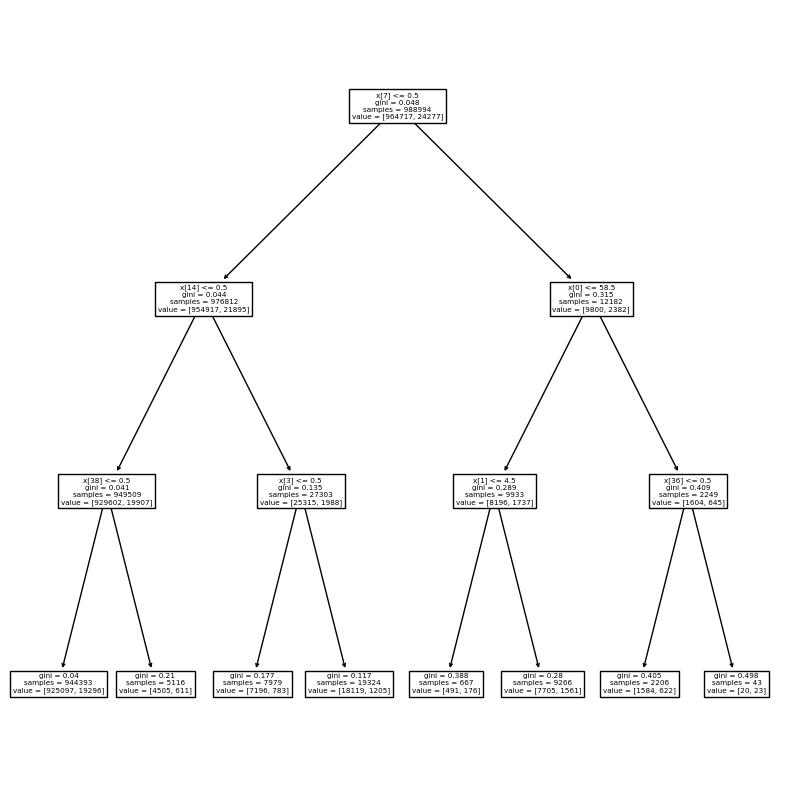

In [ ]:
f, ax = plt.subplots(figsize=(10, 10))
plot_tree(tree_clf, ax=ax);

In [ ]:
feature_names = ohe.get_feature_names_out()
print(feature_names)


['PRIM_CONTRIBUTORY_CAUSE_c_ANIMAL'
 'PRIM_CONTRIBUTORY_CAUSE_c_BICYCLE ADVANCING LEGALLY ON RED LIGHT'
 'PRIM_CONTRIBUTORY_CAUSE_c_CELL PHONE USE OTHER THAN TEXTING'
 'PRIM_CONTRIBUTORY_CAUSE_c_DISREGARDING OTHER TRAFFIC SIGNS'
 'PRIM_CONTRIBUTORY_CAUSE_c_DISREGARDING ROAD MARKINGS'
 'PRIM_CONTRIBUTORY_CAUSE_c_DISREGARDING STOP SIGN'
 'PRIM_CONTRIBUTORY_CAUSE_c_DISREGARDING TRAFFIC SIGNALS'
 'PRIM_CONTRIBUTORY_CAUSE_c_DISREGARDING YIELD SIGN'
 'PRIM_CONTRIBUTORY_CAUSE_c_DISTRACTION - FROM INSIDE VEHICLE'
 'PRIM_CONTRIBUTORY_CAUSE_c_DISTRACTION - FROM OUTSIDE VEHICLE'
 'PRIM_CONTRIBUTORY_CAUSE_c_DISTRACTION - OTHER ELECTRONIC DEVICE (NAVIGATION DEVICE, DVD PLAYER, ETC.)'
 'PRIM_CONTRIBUTORY_CAUSE_c_DRIVING ON WRONG SIDE/WRONG WAY'
 'PRIM_CONTRIBUTORY_CAUSE_c_DRIVING SKILLS/KNOWLEDGE/EXPERIENCE'
 'PRIM_CONTRIBUTORY_CAUSE_c_EQUIPMENT - VEHICLE CONDITION'
 'PRIM_CONTRIBUTORY_CAUSE_c_EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST'
 'PRIM_CONTRIBUTORY_CAUSE_c_EXCEEDING AUTHORIZED SPEED L

In [ ]:
print(X_train.columns[7])

PEDESTRIAN


In [ ]:
print(X_train.columns[14])


DISREGARDING TRAFFIC SIGNALS


In [ ]:
print(X_train.columns[38])

PHYSICAL CONDITION OF DRIVER


In [ ]:
print(X_train.columns[3])

DRIVER


In [ ]:
print(X_train.columns[0])

AGE_p


In [ ]:
print(X_train.columns[1])

CRASH_HOUR_c


In [ ]:
print(X_train.columns[36])

OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER
